In [ ]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.5 MB/s eta 0:00:00
using cpu device.


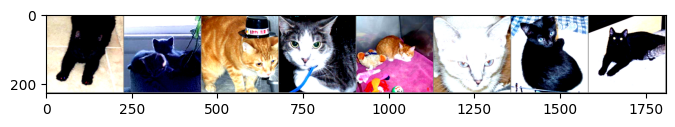

cat
cat
cat
cat
cat
cat
cat
cat


In [ ]:
# !pip install wget
!pip install pyunpack
!pip install patool
from pyunpack import Archive
# !pip install patool
import os

import sys
import json
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# wget.download("http://fenggao-image.stor.sinaapp.com/dogscats.zip","./")

Archive("./drive/MyDrive/cat_dog.rar").extractall("./")

# ! wget http://fenggao-image.stor.sinaapp.com/dogscats.zip
# ! unzip dogscats.zip

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}


# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,# download=True, transform=data_transform["train"])
train_dataset = datasets.ImageFolder("./cat_dog/cat_dog/train",transform=data_transform["train"])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,shuffle=True, num_workers=2)
validate_dataset = datasets.ImageFolder("./cat_dog/cat_dog/val",transform=data_transform["val"])
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=8,shuffle=False, num_workers=2)

# loader_test = torch.utils.data.DataLoader(dsets_test['test'], batch_size=1, shuffle=False, num_workers=0)

train_num = len(train_dataset)
val_num = len(validate_dataset)

classes=['cat','dog']

def imshow(img):
    plt.figure(figsize=(8,8))
    img = img / 2 + 0.5     # 转换到 [0,1] 之间
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# 得到一组图像
images, labels = next(iter(validate_loader))
# 展示图像
imshow(torchvision.utils.make_grid(images))
# 展示图像的标签
for j in range(8):
    print(classes[labels[j]])

In [ ]:


net = resnet34(1000)
! wget "https://download.pytorch.org/models/resnet34-333f7ec4.pth"
model_weight_path = "./resnet34-333f7ec4.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
# for name, parameter in net.named_parameters():
#     parameter.requires_grad = False
# net = resnext50_32x4d(1000)
# wget.download("https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth","./resnext50_32x4d.pth")
# model_weight_path = "./resnext50_32x4d.pth"
# assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
# net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))


# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel,2)
net.to(device)

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

epochs = 1
best_acc = 0.0
train_steps = len(train_loader)
for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                  epochs,
                                                                  loss)

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            # loss = loss_function(outputs, test_labels)
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

            val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                        epochs)

    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))


print('Finished Training')

--2023-10-22 02:28:51--  https://download.pytorch.org/models/resnet34-333f7ec4.pth
Resolving download.pytorch.org (download.pytorch.org)... 18.239.225.75, 18.239.225.61, 18.239.225.41, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.225.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87306240 (83M) [application/octet-stream]
Saving to: ‘resnet34-333f7ec4.pth’

resnet34-333f7ec4.p 100%[===================>]  83.26M   118MB/s    in 0.7s    

2023-10-22 02:28:52 (118 MB/s) - ‘resnet34-333f7ec4.pth’ saved [87306240/87306240]

valid epoch[1/1]: 100%|██████████| 250/250 [05:32<00:00,  1.33s/it]
[epoch 1] train_loss: 0.111  val_accuracy: 0.990
Finished Training


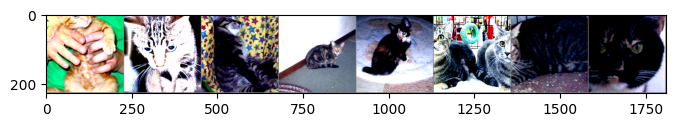

cat
cat
cat
cat
cat
cat
cat
cat
predicted:

cat
cat
cat
cat
cat
cat
cat
cat


In [ ]:
# 得到一组图像
images, labels = next(iter(validate_loader))
# 展示图像
imshow(torchvision.utils.make_grid(images))
# 展示图像的标签
for j in range(8):
    print(classes[labels[j]])


outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print("predicted:\n")
# 展示预测的结果
for j in range(8):
    print(classes[predicted[j]])

In [ ]:
filenameAndValue={}
#Archive("./drive/MyDrive/cat_dog.rar").extractall("./")
test_dataset = datasets.ImageFolder("./cat_dog/cat_dog/T",transform=data_transform["val"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1 ,shuffle=False, num_workers=2)

pic_index = 0
for inputs,classes in test_loader:#数据和标签
    inputs = inputs.to(device)
    classes = classes.to(device)
    outputs = net(inputs)#获得输出
    _,preds = torch.max(outputs.data, 1)

    key = test_dataset.imgs[pic_index][0][25:-4]
    print(key+" : "+classes[outputs])
    pic_index = pic_index + 1
    filenameAndValue[key] = preds[0]

# coding: utf-8
#输出成csv
with open("./result.csv",'a+') as f:
  for item in filenameAndValue.items():
    f.write("{},{}\n".format(item[0],item[1]))


0
1
10
100
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
101
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
102
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
103
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
104
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
105
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
106
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
107
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
108
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
109
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
11
110
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
111
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
112
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
113
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
114
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
115
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
116
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
117
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
118
1180
1181
1182